<h1>Chapter 6: Decision Trees</h1>

<em>Decision Trees</em> are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets.

They are also fundamental components of Random Frorest, which are among the most powerful Machine Learning algorithms available today. 

<h2>6.1 Traning and Visualising a Decision Tree</h2>

To understand Decision Trees, let's build one and take a look at how it makes predictions. 

The following code trains a DecisionTreeClassifier on the iris dataset:

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame = True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualise the trained Decision Tree by first using the export_graphviz() function to output a graph definition file called iris_tree.dot:

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf, 
    out_file = "iris_tree.dot",
    feature_names = ["petal length (cm)", "petal width (cm)"],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)

Then you can use graphviz.Source.from_file() to load and display the file in a Jupyter notebook:

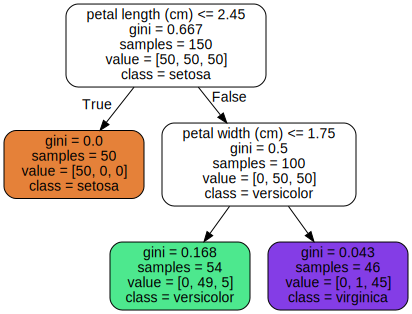

In [5]:
from graphviz import Source

Source.from_file("iris_tree.dot")

<h2>6.2 Making Predictions</h2>

Suppose you find an iris flower and you want to classify it based on its petals. You start at the root node (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45cm. If it is, then you move down to the root's left child node (depth 1, left). In this case, it is a leaf node (i.e. it doesn't have any child nodes), so it doesn't ask any more questions: simply look at the predicted class fro taht node, and the Decision Tree predicts that the flower is an Iris setosa.

Now suppose you find another flower, and this time the petal length is greater than 2.45cm. You again start at the root but now move down to its right child node (depth 1, right). This is not a leaf node, it is a split lnode, so it asks another question: is the petal width smaller than 1.75cm? If it is, then your flower is most likely an Iris versicolor (depth 2, left). If not, it is likely an Iris virginica (depth 2, right). 

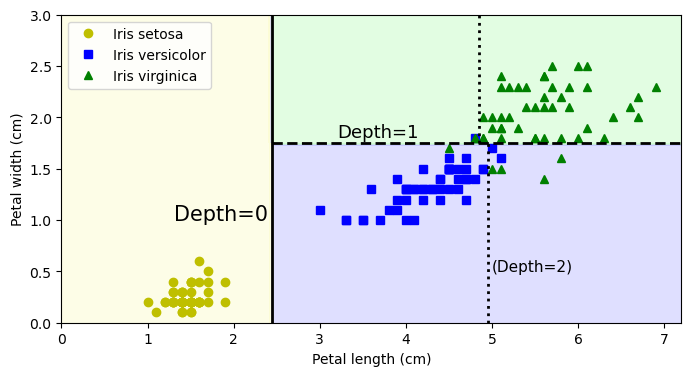

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
plt.show()

The above plot shows the Decision Tree's decision boundaries.

The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45cm. Since the lefthand area is pure (only Iris setosa), it can't be split any further. 

However, the righthand area is impure, so the depth-1 right node splits it at petal width=1.75cm (represented by the dashed line). Since max_depth was set to 2, the Decision Tree stops right there. If you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the two vertical lines).

<h2>6.3 Estimating Class Probabilities</h2>

A decision tree can also estimate the probability that an instance belongs to a particlar class $k$. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. For example, suppose you have a flower whose petals are 5cm and 1.5cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree outputs the following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor (class 1) because it has the highest probabilitiy.

In [7]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

<h2>6.4 The CART Training Algorithm</h2>

Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees (also called "growing trees"). 

The algorithm works by first splitting the training set into two subsests using a single feature $k$ and a threshold $t_{k}$ (e.g. "petal length $\leq$ 2.45cm"). How does it choose $k$ and $t_{k}$? It searches for the pair $(k, t_{k})$ that produces the purest subsets, weighted by their size. 

Once the CART algorithm has sucssessfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing one it reaches the maximum depth (defined by the max_depth hyperparameter), or if it can't find a split that will reduce impureity.

<h2>6.5 Computational Complexity</h2>

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires going through roughly $O(log_{2}(m))$ nodes.

Since each node only requires checking the value of one feature, the overall prediction complexity is $O(log_{2}(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The training algorithm compares all features (or less if max_features is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n \times m log_{2}(m))$.

<h2>6.6 Gini Impurity or Entropy</h2>

By default, the DecisionTreeClassifier class uses the Gini impurity measure, but you can select the <em>entropy</em> impurity measure instead by setting the criterion hyperparameter to "entropy". In Machine Learning, a set's entropy is zero when it contains instances of only one class.

So, should you use Gini impurity or entropy? The truth is, most of the time it doesn't matter: they lead to similar trees. Gini impurity is slightly faster to compute, so it's a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

<h2>6.7 Regularisation Hyperparameters</h2>

Decision Trees make very few assumptions about the traingin data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting is very closely - indeed, it is most likely overfitting it. Such a model is often called a nonparametric model, not because it doesn't have any parameters but because the number of parameters isn't determined prior to training, so the model structure is free to stick closely to the data.

In constrast, a parametric model, such as a linear model, has a predetermined number of parameters, so it's degree of freedom is limited, reducing the risk of overfitting and increasing the risk of underfitting.

To avoid overfitting the training data in the case of Decision Trees, you need to restrict the freedom during training, which we call regularisaiton. The regularisation hyperparameters depend on the algorithm used, but generally you can at least retrict the maximum depth.

Let's test regularisation on the moons dataset. We'll train one Decision Tree without regularisation, and another with min_samples_leaf=5. 

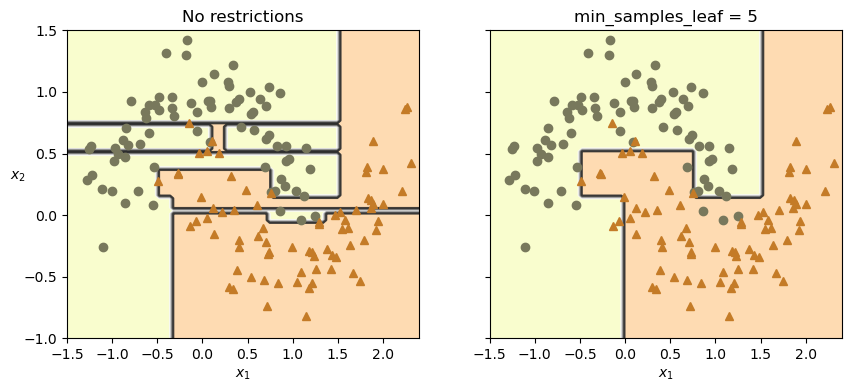

In [9]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

The unregularised model on the left is clearly overfitting, and the regularised model on the right will probably generalise better. 

In [10]:
X_moons_test, y_moons_test = make_moons(n_samples = 1000, noise = 0.2, random_state = 43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [11]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92